In [5]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt

import datetime
import pytz

bangkok_tz = pytz.timezone('Asia/Bangkok')


In [54]:
tabname = 'ACTW'

mydate = "2024-08-18"



In [55]:


## prepare

date_start = mydate
sharding_name = (datetime.datetime.strptime(date_start,"%Y-%m-%d")).strftime(format='%Y%m%d')
date_end = ((datetime.datetime.strptime(date_start,"%Y-%m-%d")) + datetime.timedelta(days=1)).strftime(format = "%Y-%m-%d")

# table_id = "bims-432306.BIMS_data."+tabname+"_"+sharding_name

## Download from BIMS
url = f'http://110.49.150.135:4002/CPU/?command=DataQuery&uri=dl:tab{tabname}&format=html&mode=date-range&p1={date_start}T00:00:00&p2={date_end}T00:00:00'

page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

table = soup.find('table')
rows = table.find_all('tr')
data = []
for row in rows:
    cols = row.find_all(['td', 'th'])
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])

df = pd.DataFrame(data[1:],columns=data[0])

collist= [col for col in df.columns if col not in ['TimeStamp','Record','date']]

# df['TimeStamp'] = pd.to_datetime(df['TimeStamp']).dt.tz_localize(bangkok_tz)

for col in collist:
    df[col] = df[col].astype('float')

df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

In [27]:
df.head()

,TimeStamp,Record,WaterTemp_ACTW,Conductivity,Salinity,ACTWVoltage
0,2024-08-17 00:00:00,279403,31.13,49.69,28.55,12.5
1,2024-08-17 00:01:00,279404,31.11,49.57,28.48,12.5
2,2024-08-17 00:02:00,279405,31.15,49.69,28.54,12.5
3,2024-08-17 00:03:00,279406,31.10,49.45,28.42,12.5
4,2024-08-17 00:04:00,279407,31.09,49.44,28.41,12.5


Working on WaterTemp_ACTW
IQR:
Q1: 30.95, Q3: 31.32
Outliers detected: 0
Data after removing outliers: 1440


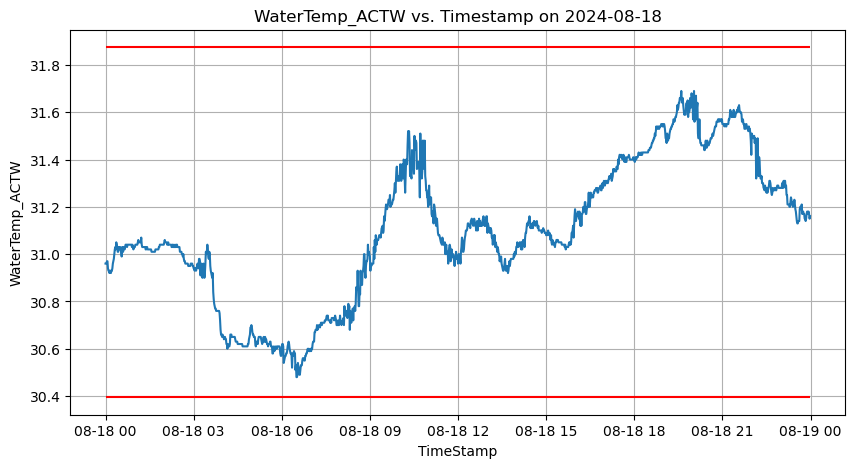

Working on Conductivity
IQR:
Q1: 42.12, Q3: 48.95
Outliers detected: 2
Data after removing outliers: 1438


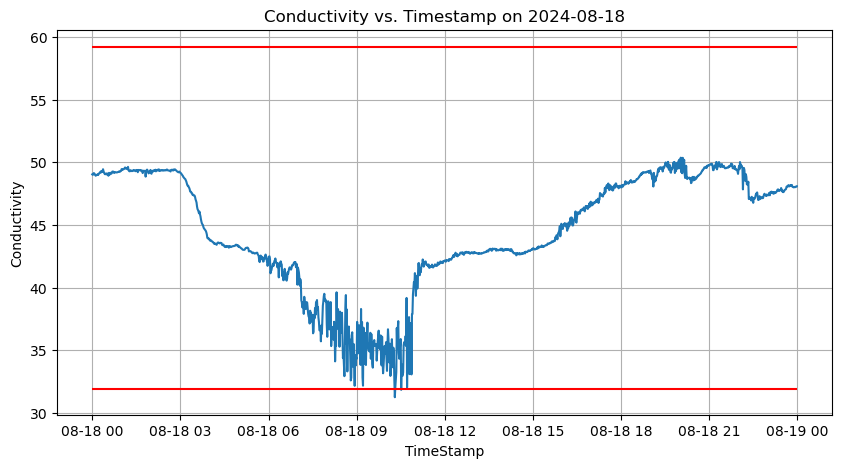

Working on Salinity
IQR:
Q1: 23.90, Q3: 27.93
Outliers detected: 8
Data after removing outliers: 1432


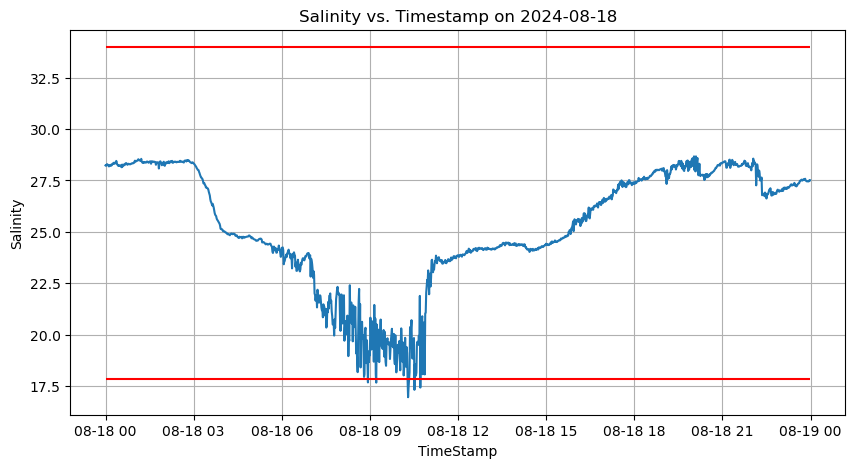

Working on ACTWVoltage
IQR:
Q1: 12.43, Q3: 12.98
Outliers detected: 45
Data after removing outliers: 1395


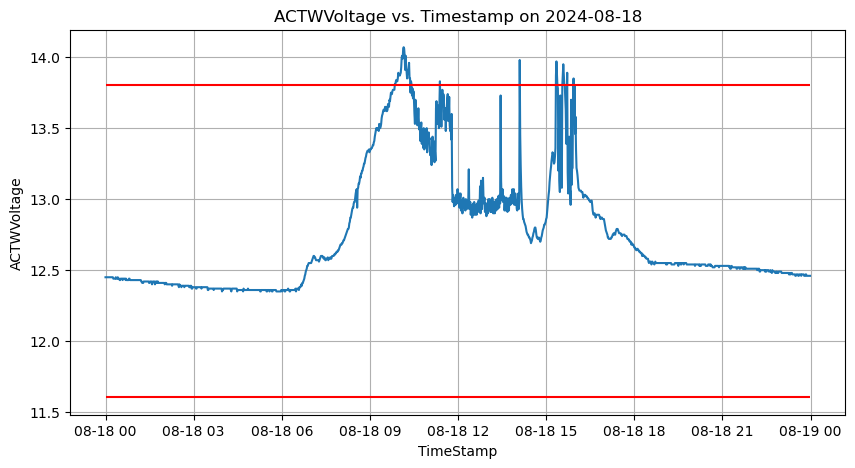

In [56]:
for col in collist:
    print("Working on "+ col)
    #iqr
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    # Remove outliers
    df_cleaned = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)].copy()
    print("IQR:")
    print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}")
    print(f"Outliers detected: {outliers.shape[0]}")
    print(f"Data after removing outliers: {df_cleaned.shape[0]}")

    plt.figure(figsize=(10, 5))
    plt.plot(df['TimeStamp'], df[col])
    plt.hlines(y=[upper_bound,lower_bound],xmin = df['TimeStamp'].min(),xmax = df['TimeStamp'].max(),color='red')
    plt.xlabel('TimeStamp')
    plt.ylabel(col)
    plt.title(col+' vs. Timestamp on '+mydate)
    plt.grid(True)
    plt.show()